## IMPORTING THE REQUIRED LIBRARIES

In [1]:
#Make sure all the following libraries are installed before running the application. 
import pandas as pd
import numpy as np
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings

from keras.preprocessing import sequence
from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SimpleRNN, BatchNormalization
from keras.models import model_from_json

warnings.filterwarnings("ignore")
%matplotlib inline



Using TensorFlow backend.


## LOADING TRAINING AND TESTING DATA

In [2]:
#load the csv file containing the column names 
column_name = pd.read_csv("Field Names.csv", header = None)

In [3]:
#Convert the array into list
new_columns = list(column_name[0].values)

In [4]:
#adding difficulty 
new_columns += ['class', 'difficulty']

In [5]:
#loading train and test data files
train_data = pd.read_csv('KDDTrain+.txt', names = new_columns)
test_data = pd.read_csv('KDDTest+.txt', names = new_columns)

In [6]:
#Training data sample
print("The training data is")
train_data.tail()

The training data is


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.0,0.00,0.0,0.00,0.0,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.0,0.72,0.0,0.01,0.0,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125972,0,tcp,ftp_data,SF,151,0,0,0,0,0,...,0.30,0.03,0.30,0.0,0.00,0.0,0.00,0.0,normal,21


In [7]:
#Output total rows and columns of dataframe
print(f"The shape of the training dataframe is : {train_data.shape}")

The shape of the training dataframe is : (125973, 43)


In [8]:
#Same for testing
print("The testing data is")
test_data.head()

The testing data is


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [9]:
#Idem dito ^
print(f"The shape of the testing dataframe is : {test_data.shape}")

The shape of the testing dataframe is : (22544, 43)


In [10]:
#Load attacks.txt containing the attack categories
map_attacks = [x.strip().split() for x in open('attacks.txt', 'r')]
map_attacks = {k:v for (k,v) in map_attacks}

In [11]:
#Replace the "class" column values to 5 attack categories in training and testing dataframe
train_data['class'] = train_data['class'].replace(map_attacks)
test_data['class'] = test_data['class'].replace(map_attacks)

In [12]:
train_data = shuffle(train_data)

## DATA PREPROCESSING

In [13]:
#separate the training dataframe into feature columns and label columns
X = train_data.drop('class', axis = 1) #Independent features
y = train_data['class'] #Dependent features (Labels)

In [14]:
#Converting String to Integer with get_dummies by pandas
columns = ['protocol_type', 'service', 'flag']
X_new = pd.get_dummies(X, columns = columns, drop_first = True)

In [15]:
#Idem dito for class ^
y_new = train_data['class']
y_new = pd.get_dummies(y_new)

In [16]:
#Split data: 80% training and 20% testing 
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2, random_state = 101)

In [17]:
#Use StandardScaler() to standardize data - explained in Honours Project
sc = StandardScaler()
sc.fit(np.array(X_train))
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

MODEL 1: 

First model. This model contains all the dense layers. In dense layers each node or neuron in a layer is connected to all the nodes/neurons in the preceding layer, further explained in Honours Document. 

In [18]:
#Use the keras's sequential API 
#First dense layer takes an input parameter as 256 (number of neurons in the first layer).
#The second parameter "input_dim" corresponds to the input features. 
#Use "relu" as activation function.
#The activation function for last dense layer is "softmax" because of the multiple classes, further explained in document.
#Set dropout for 10%. 
model1 = Sequential()
model1.add(Dense(64, input_dim = 120, activation = "relu", kernel_initializer = "lecun_normal"))
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(5, activation = "softmax"))

W0128 10:20:14.529850 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0128 10:20:14.532920 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0128 10:20:14.535627 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0128 10:

In [19]:
#Summary of model architecture listing information about parameters per layer. 
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                7744      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 16,709
Trainable params: 16,709
Non-trainable params: 0
_________________________________________________________________


In [20]:
#Three paramaters: 
#Loss - The loss function.
#Optimizer - To minimize the loss function.
#Metrics - The mode of evaluation for our model.
#"categorical_loss" - is used because of the multi-class classifcation problem.
#"adam" - The updated version of SGD.
optim = optimizers.SGD(lr = 0.0001)
model1.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

W0128 10:20:47.048588 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0128 10:20:47.056501 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



In [21]:
#Fit the model on our data.
#X_train - The feature columns of the training data.
#y_train - The labels columns of the training data.
#validation_data - The validation data
#batch_size and epochs further explained in document. 
history = model1.fit(X_train, y_train, 
          validation_data = (X_test, y_test),
          batch_size = 32, 
          epochs = 20)

W0128 10:20:56.260170 35184372372032 deprecation.py:323] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0128 10:20:56.317167 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0128 10:20:56.344094 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1020: Th

Train on 100778 samples, validate on 25195 samples
Epoch 1/20


W0128 10:20:57.697775 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0128 10:20:57.700337 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:216: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0128 10:20:58.423499 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:223: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variab

100778/100778 [==============================] - 11s 110us/step - loss: 1.3476 - acc: 0.6117 - val_loss: 1.0346 - val_acc: 0.8511
Epoch 2/20
100778/100778 [==============================] - 9s 85us/step - loss: 0.8406 - acc: 0.8766 - val_loss: 0.6801 - val_acc: 0.8922
Epoch 3/20
100778/100778 [==============================] - 9s 88us/step - loss: 0.5775 - acc: 0.9061 - val_loss: 0.4879 - val_acc: 0.9161
Epoch 4/20
100778/100778 [==============================] - 9s 89us/step - loss: 0.4332 - acc: 0.9216 - val_loss: 0.3801 - val_acc: 0.9240
Epoch 5/20
100778/100778 [==============================] - 9s 88us/step - loss: 0.3494 - acc: 0.9323 - val_loss: 0.3146 - val_acc: 0.9405
Epoch 6/20
100778/100778 [==============================] - 9s 88us/step - loss: 0.2961 - acc: 0.9468 - val_loss: 0.2709 - val_acc: 0.9503
Epoch 7/20
100778/100778 [==============================] - 9s 87us/step - loss: 0.2591 - acc: 0.9520 - val_loss: 0.2395 - val_acc: 0.9544
Epoch 8/20
100778/100778 [==========

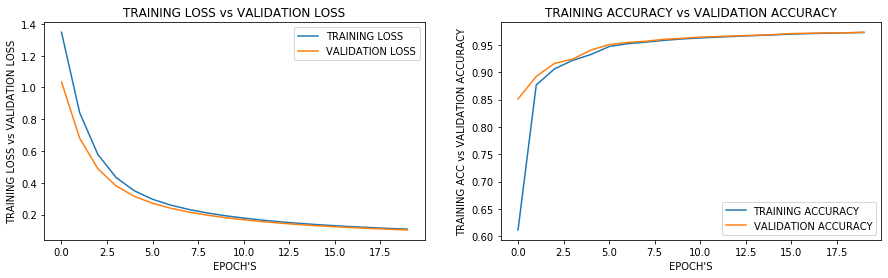

In [22]:
#use matplitlib to draw the plots
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = "TRAINING LOSS")
plt.plot(history.history['val_loss'], label = "VALIDATION LOSS")
plt.title("TRAINING LOSS vs VALIDATION LOSS")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING LOSS vs VALIDATION LOSS")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label = "TRAINING ACCURACY")
plt.plot(history.history['val_acc'], label = "VALIDATION ACCURACY")
plt.title("TRAINING ACCURACY vs VALIDATION ACCURACY")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING ACC vs VALIDATION ACCURACY")
plt.legend(loc = "best")

Explained in Results section.

Load and save model 1:

In [23]:
#Serialize model 1 , save with json. 
model_json = model1.to_json() 
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
model1.save_weights('model1_weights.h5')
print("Saved model to disk")

Saved model to disk


In [24]:
# load model 1. 
json_file = open("model1.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json) 
loaded_model.load_weights("model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


Model 2: 

Single Dense Hidden Layer with Output Layer

In [25]:
model2 = Sequential()
model2.add(Dense(32, input_dim = 120, activation = "relu", kernel_initializer = "lecun_normal"))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(5, activation = "softmax"))

W0128 10:30:47.205537 35184372372032 module_wrapper.py:139] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0128 10:30:47.224908 35184372372032 deprecation.py:506] From /net/service0005/share/systems/satori-portal.mit.edu/software/anaconda3/2019.10_powerai_ood/envs/powerai/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
#List summary again 
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                3872      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
Total params: 5,221
Trainable params: 5,157
Non-trainable params: 64
_________________________________________________________________


In [27]:
#SGD used instead of Adam!
optim2 = optimizers.Adam(lr = 0.0001)
model2.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [28]:
#Train model and validate. 
history2 = model2.fit(X_train, y_train, 
           batch_size = 32, 
           epochs = 30, 
           validation_data = (X_test, y_test))

Train on 100778 samples, validate on 25195 samples
Epoch 1/30
100778/100778 [==============================] - 14s 138us/step - loss: 1.5872 - acc: 0.4137 - val_loss: 1.1815 - val_acc: 0.7023
Epoch 2/30
100778/100778 [==============================] - 13s 133us/step - loss: 0.9622 - acc: 0.7240 - val_loss: 0.8227 - val_acc: 0.8278
Epoch 3/30
100778/100778 [==============================] - 14s 135us/step - loss: 0.6636 - acc: 0.8290 - val_loss: 0.5751 - val_acc: 0.8977
Epoch 4/30
100778/100778 [==============================] - 14s 136us/step - loss: 0.5106 - acc: 0.8705 - val_loss: 0.4532 - val_acc: 0.9197
Epoch 5/30
100778/100778 [==============================] - 14s 136us/step - loss: 0.4249 - acc: 0.8901 - val_loss: 0.3513 - val_acc: 0.9318
Epoch 6/30
100778/100778 [==============================] - 14s 136us/step - loss: 0.3675 - acc: 0.9063 - val_loss: 0.3211 - val_acc: 0.9478
Epoch 7/30
100778/100778 [==============================] - 14s 135us/step - loss: 0.3245 - acc: 0.9178

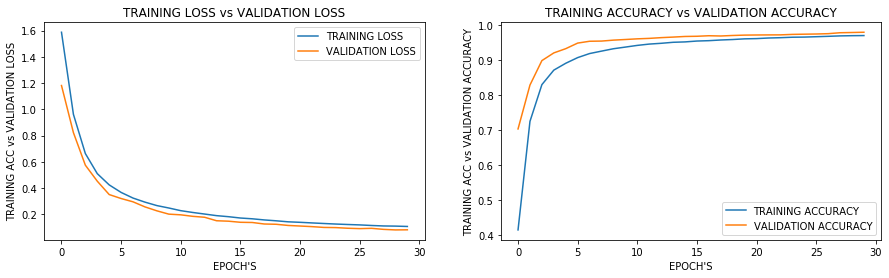

In [29]:
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1) 
plt.plot(history2.history['loss'], label = "TRAINING LOSS") 
plt.plot(history2.history['val_loss'], label = "VALIDATION LOSS") 
plt.title("TRAINING LOSS vs VALIDATION LOSS")
plt.xlabel("EPOCH'S") 
plt.ylabel("TRAINING ACC vs VALIDATION LOSS") 
plt.legend(loc = "best") 

plt.subplot(1, 2, 2)
plt.plot(history2.history['acc'], label = "TRAINING ACCURACY") 
plt.plot(history2.history['val_acc'], label = "VALIDATION ACCURACY") 
plt.title("TRAINING ACCURACY vs VALIDATION ACCURACY") 
plt.xlabel("EPOCH'S") 
plt.ylabel("TRAINING ACC vs VALIDATION ACCURACY") 
plt.legend(loc = "best") 

Explained in results section. 